#  Прогнозирование заказов такси

**Задача:** по историческим данным о заказах такси в аэропортах построить модель прогнозирования количества заказов на следующий час для привлечения большего числа водителей в периоды пиковой нагрузки. 

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**План работы:**

- загрузика и ресемплирование данных
- анализ данных
- подготовка признаков
- обучение моделей
- проверка на тестовой выборке

In [1]:
#импортируем необходимые библиотека
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import TimeSeriesSplit

from sklearn.dummy import DummyRegressor

In [2]:
#откроем файл с данными, указав дату в качестве индекса
try:
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#изучим основную информацию о данных
display(data.head(), data.tail(), data.info(), data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
data.index.is_monotonic

True

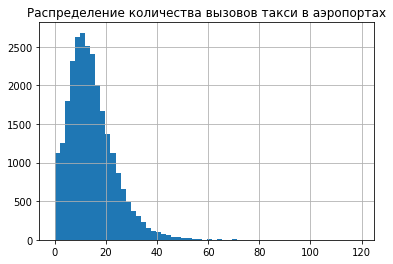

In [5]:
data.hist(bins=60);
plt.title('Распределение количества вызовов такси в аэропортах')
plt.show()

Для анализа доступны 26 496 записей о количестве вызовов такси с 1 марта 2018 по 31 августа 2018 года с разбивкой по 10-минутным интервалам. Данные расположены в порядке возрастания времени, пропусков нет. Распределение заказов внешне похоже на распределение Пуассона с выраженным хвостом в область больших значений.

Для удобства дальнейшней работы выполним респемлирование по одному часу (час - целевой период для прогнозирования).

In [6]:
data = data.resample('1H').sum()

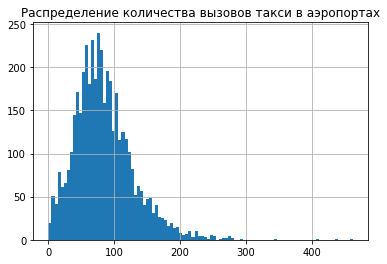

In [7]:
data.hist(bins=100);
plt.title('Распределение количества вызовов такси в аэропортах')
plt.show()

Распределение после ресемплинга сместилось.
Построим также график временного ряда:

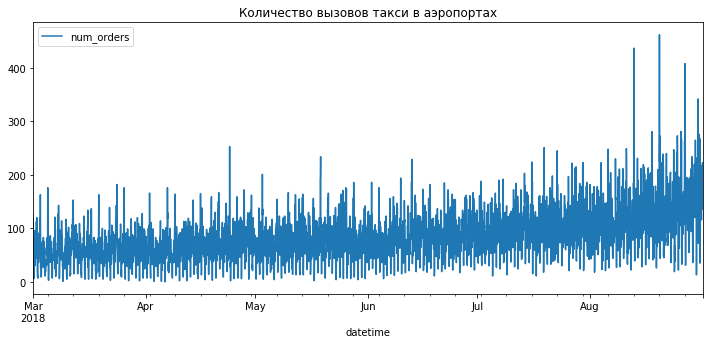

In [8]:
data.plot(figsize=(12, 5));
plt.title('Количество вызовов такси в аэропортах')
plt.show()

Выберем три произвольные недели с понедельника по воскресенье и построим для них графики:

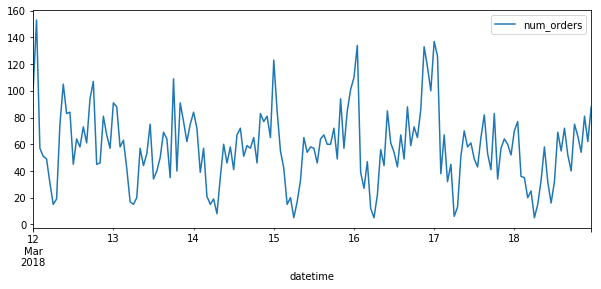

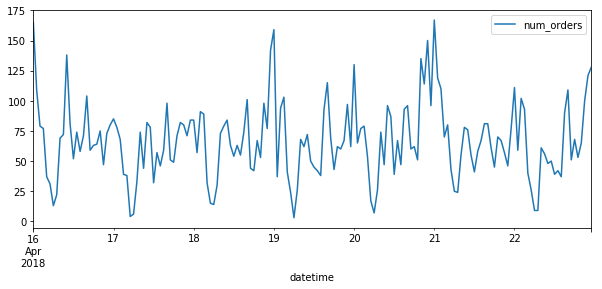

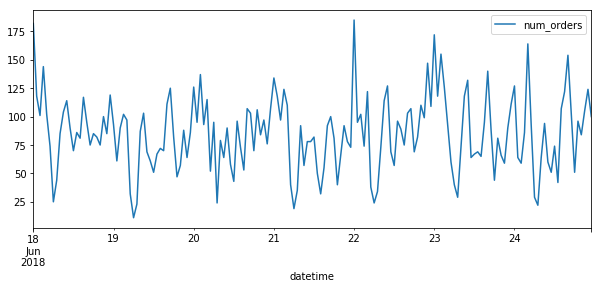

In [9]:
ax=data['2018-03-12':'2018-03-18'].plot(figsize=(10, 4));
data['2018-04-16':'2018-04-22'].plot(figsize=(10, 4));
data['2018-06-18':'2018-06-24'].plot(figsize=(10, 4));

Во всех трех случаях видим ярко выраженный пик после 0 часов в понедельник (прилетающие "в ночь" с вск на пн), характерные "провалы" в районе 3-4 утра и возрастающую интенсивность в ночное время ближе к концу недели.

Построим график скользящего среднего с размером окна в 24 часа.

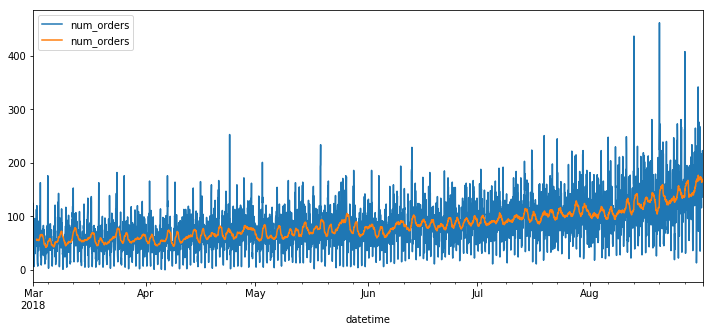

In [10]:
ax = data.plot(figsize=(12, 5));
data.rolling(24).mean().plot(figsize=(12, 5), ax=ax);

Видим достаточно четкий возрастающий тренд, т.е., вероятно, мы имеем дело с нестационарным процессом. Попробуем продиффиренцировать ряд и построить график еще раз:

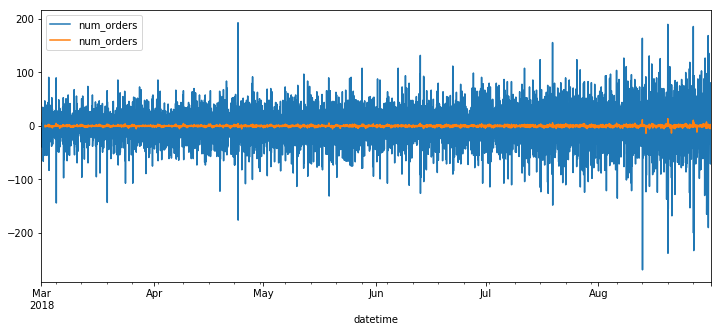

In [11]:
ax = data.diff().plot(figsize=(12, 5));
data.diff().rolling(24).mean().plot(figsize=(12, 5), ax=ax);

График превратился в константу, следовательно тренд описывается линейной зависимостью.</br>
Проверим стационарность критерием Дики-Фуллера:

In [12]:
print('P-value:', adfuller(data['num_orders'])[1])

P-value: 0.02894005140261345


Согласно этому критерию мы можем отвергнуть нулевую гипотезу о нестационарности ряда (честно говоря, я не до конца поняла, как это сочетается с наличием тренда в данных).

Проведем разбиение данных на тренд, сезонность и шум с помощью метода decompose

In [13]:
decomposed_data = seasonal_decompose(data)

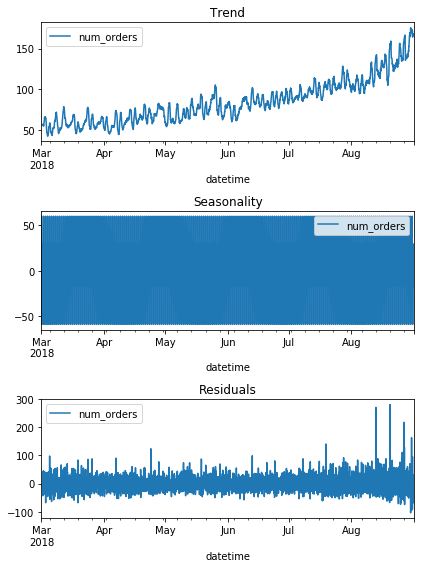

In [14]:
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Сезонность крупнее:

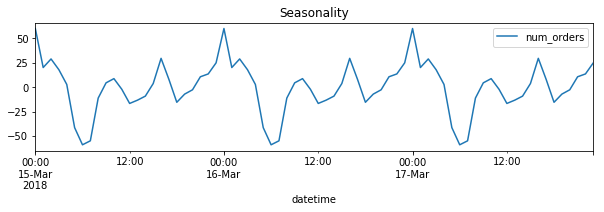

In [15]:
plt.figure(figsize=(10, 8))

plt.subplot(312)
decomposed_data.seasonal['2018-03-15':'2018-03-17'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.show()

Еще раз убеждаемся в наличии тренда (это вполне логично - август самый популярный месяц для отпусков и количество людей в аэропортах растет - а значит, растёт и количество вызовов такси.
В дневной сезонности можно четко выделить 4 периода: 
- с 0 до 6 утра - пик заказов приходится на полночь, потом количество плавно снижается до нуля (в полночь транспорт уже не ходит, остается только такси, а после 2 ночи вылетов и прилетов уже нет
- с 6 утра количество вызовов растёт, немного снижаясь к 12
- с 12 снова растёт с пиком в районе 16 часов (возможно это связано с графиками прилетов-вылетов)
- с 18 наблюдается постоянный рост с пиком к полуночи (многие предпочитают вечерние рейсы)

### Выводы

- мы имеем дело с временным рядом с возрастающим линейным трендом
- согласно критерию Дики-Фуллера временной ряд стационарен
- дневная "сезонность" имеет 4 выраженных периода по 6 часов
- пик вызовов приходится на полночь
- поведение пассажиров в будни несколько отличается от поведения в выходные

## Подготовка признаков

Для построения модели определим функцию, которая добавит столбцы с данными:
- час, день, месяц
- день недели, является ли он выходным днем
- скользящее среднее (размер окна - параметр функции)
- период дня: ночь (0-6), утро (6-12), день (12-18) (оставшиеся без категории столбцы - это вечер 18-23)
- столбцы со смещением на один час (количество столбцов - параметр функции)

In [16]:
def make_features(data, rolling_mean_size, max_lag):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['month'] = data.index.month 
    data['dayofweek'] = data.index.dayofweek
    data['isweekend'] = data['dayofweek'].apply(lambda x: 1 if x == 5 or x == 6 else 0)
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    data['isnight'] = data['hour'].apply(lambda x: 1 if x < 6 else 0)
    data['ismorning'] = data['hour'].apply(lambda x: 1 if x >= 6 and x < 12 else 0)
    data['isday'] = data['hour'].apply(lambda x: 1 if x >= 12 and x < 18 else 0)
    #data['isevening'] = data['hour'].apply(lambda x: 1 if x >= 18 else 0)
    #data['ishotseason'] = data['month'].apply(lambda x: 1 if x == 8 or x == 7 else 0)
    #data['issemihotseason'] = data['month'].apply(lambda x: 1 if x == 6 or x == 5 else 0)
        
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

Добавим признаки в датасет. Сезонность связана с 24-х часовым периодом, поэтому и для скользящего среднего, и для построения столбцов со смещением используем период в 23 часа. Образовавшиеся строки с пропусками просто удалим - данные для них нам взять неоткуда.

In [17]:
make_features(data, 24, 23)
data.dropna(inplace = True)

In [18]:
data.shape

(4392, 33)

Разобьем данные на обучающую и тестовую выборки (отложим 10% датасета). Выделим целевой признак.

In [19]:
train_data, test_data = train_test_split(data, shuffle=False, test_size=0.1)

In [20]:
train_target = train_data['num_orders']
train_features = train_data.drop(columns='num_orders')
test_target = test_data['num_orders']
test_features = test_data.drop(columns='num_orders')

### Выводы

Для построения модели мы создали 34 новых столбца с признаками, разбили данные на тестовую и обучающую выборки.

## Построение моделей

Для решения задачи прогнозирования будем использовать линейные модели из библиотеки sklearn - обычную линейную регрессию, ридж и лассо регрессию с регуляризацией, модель ElasticNet, сочетающую в себе свойства Ridge и Lasso. Также попробуем обучить метод ближайших соседей.

In [21]:
#определим метрику
def rmse(target, predict):
    return mean_squared_error(target, predict) ** 0.5

В работе с временными рядами нельзя использовать обычную кросс-валидацию, поскольку произойдет "утечка" целевого признака. Поэтому определим функцию с помощью TimeSeriesSplit: разобьем данные на несколько фолдов и будем проводить кросс-валидацию, подключая фолды по одному на каждом шаге.

In [22]:
def timeseriesCVscore(train_features, train_target, folds, model):
    # вектор ошибок
    errors = []
    train_values = train_features.values
    target_values = train_target.values
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=folds) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(train_values):        
        X_train, X_test = train_values[train], train_values[test]
        y_train, y_test = target_values[train], target_values[test]
        #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        #print(predictions.shape)
        error = mean_squared_error(y_test, predictions) ** 0.5
        #print(error)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

### Линейная регрессия

In [23]:
lr = LinearRegression()
result = timeseriesCVscore(train_features, train_target, 5, lr)
print(result)

26.818621260808346


In [24]:
lr.fit(train_features, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
feature_importance = pd.Series(lr.coef_, index=train_features.columns)

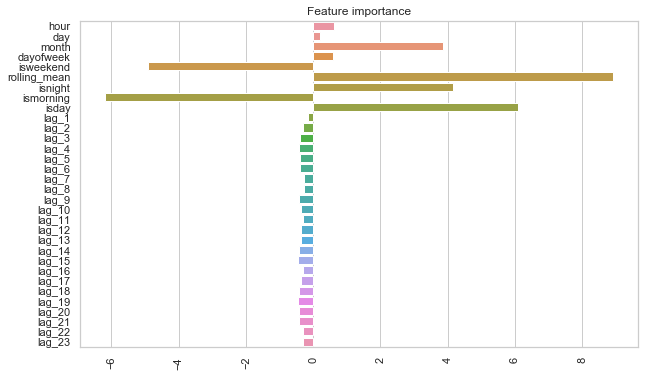

In [26]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=feature_importance, y=feature_importance.index);
plt.title('Feature importance', fontsize=12)
plt.xticks(rotation = 90)
plt.show()

Видим, что наиболее важным признаком для линейной регрессии является скользящее среднее и дополнительные параметры дня - час, месяц, утро/вечер/ночь и будни/выходные. У "лагов" вес небольшой и скорее всего их исключение не сильно повлияет на метрику.

Создадим таблицу с метриками

In [27]:
score_table = pd.DataFrame([['LinearRegression', result]], columns=['model', 'RMSE'])
score_table

,model,RMSE
0,LinearRegression,26.818621


Возможно, нам удастся улучшить метрику с меньшим количеством лагов. Проверим:

In [28]:
best_result = 10000
best_lag = 0

for lag in range(1, 25, 1):
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
    data = data.resample('1H').sum()
        
    make_features(data, 24, lag)
    data.dropna(inplace = True)
        
    train_data, test_data = train_test_split(data, shuffle=False, test_size=0.1)
    train_target = train_data['num_orders']
    train_features = train_data.drop(columns='num_orders')
    test_target = test_data['num_orders']
    test_features = test_data.drop(columns='num_orders')
        
    lr = LinearRegression()
    result = timeseriesCVscore(train_features, train_target, 5, lr)
    print('Для лага', lag, 'значение RMSE', result)
    if best_result > result:
        best_result = result
        best_lag = lag

print('Лучшее значение RMSE', best_result, 'достигнуто с лагом', best_lag)        

Для лага 1 значение RMSE 31.21515067018986
Для лага 2 значение RMSE 31.28338946750291
Для лага 3 значение RMSE 30.954563858912554
Для лага 4 значение RMSE 30.637978383338776
Для лага 5 значение RMSE 30.611886966911914
Для лага 6 значение RMSE 30.608329342480307
Для лага 7 значение RMSE 30.641236371338902
Для лага 8 значение RMSE 30.658229180141724
Для лага 9 значение RMSE 30.473752082651618
Для лага 10 значение RMSE 30.524826478719365
Для лага 11 значение RMSE 30.454004730731054
Для лага 12 значение RMSE 30.465744342561322
Для лага 13 значение RMSE 30.460021943213654
Для лага 14 значение RMSE 30.344999889084114
Для лага 15 значение RMSE 30.23922388981177
Для лага 16 значение RMSE 30.357784344256594
Для лага 17 значение RMSE 30.208070202245455
Для лага 18 значение RMSE 29.70016887234351
Для лага 19 значение RMSE 29.076104685295025
Для лага 20 значение RMSE 28.348166828108514
Для лага 21 значение RMSE 27.68189847694333
Для лага 22 значение RMSE 27.41027618153033
Для лага 23 значение RMSE

Убеждаемся, что лаг 23 выбран правильно. При этом смещение в 24 лага, по видимому, приводит к появлению корреляции между суммой 24 лагов и скользящим средним в 24 часа, поэтому модель начинает ошибаться. На графике feature_importance видно, что модель придала максимальный вес скользящему среднему и одинаковый вес лагам и занулила все остальные признаки.

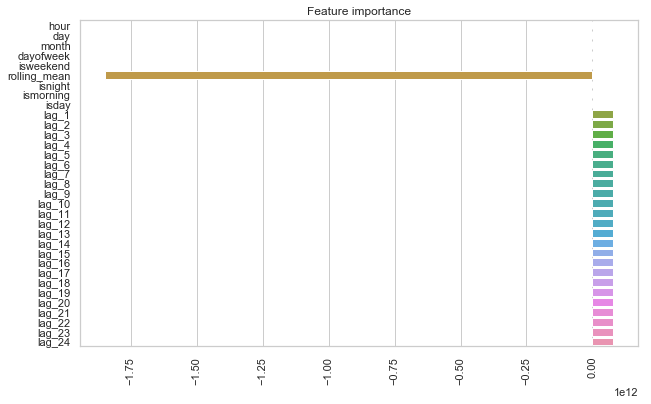

In [29]:
feature_importance = pd.Series(lr.coef_, index=train_features.columns)
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=feature_importance, y=feature_importance.index);
plt.title('Feature importance', fontsize=12)
plt.xticks(rotation = 90)
plt.show()

### ElasticNet

Протестируем модель ElasticNet применительно к этой задаче. Будем варьировать параметр альфа - вес коэффициента регуляризации и долю l1 регуляризации. А также проверим зависимость метрики от количества лагов - благодаря регуляризации проблемы коллинеарности признаков возникнуть не должно

In [30]:
best_result = 10000
best_lag = 0
best_alpha = 0
beat_l1_ratio = 0

for lag in range(1, 25, 1):
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
    data = data.resample('1H').sum()
        
    make_features(data, 24, lag)
    data.dropna(inplace = True)
        
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train_target = train['num_orders']
    train_features = train.drop(columns='num_orders')
    test_target = test['num_orders']
    test_features = test.drop(columns='num_orders')

    for alpha in [0.1, 0.5, 1.0, 10.0]:
        for l1_ratio in [0.1, 0.3, 0.5, 0.7, 0.9]:
            #print(alpha, l1_ratio)
            elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000, random_state=25)
            result = timeseriesCVscore(train_features, train_target, 5, elastic)
            if result < best_result:
                best_result = result
                best_alpha = alpha
                best_l1_ratio = l1_ratio
                best_lag = lag

print('Лучший результат', best_result, 'получен при лаге', best_lag, ', alpha =', alpha, ', l1_ratio =', l1_ratio)        

C:\Users\Dmitry\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Dmitry\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Лучший результат 26.862879817585014 получен при лаге 24 , alpha = 10.0 , l1_ratio = 0.9


In [31]:
score_table = (score_table.append({'model': 'ElasticNet', 'RMSE': best_result}, ignore_index=True));

Построим график важности фич (мы можем сделать их с текущими настройками модели, т.к. последние испробованные и есть лучшие.

In [32]:
elastic

ElasticNet(alpha=10.0, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=25, selection='cyclic', tol=0.0001, warm_start=False)

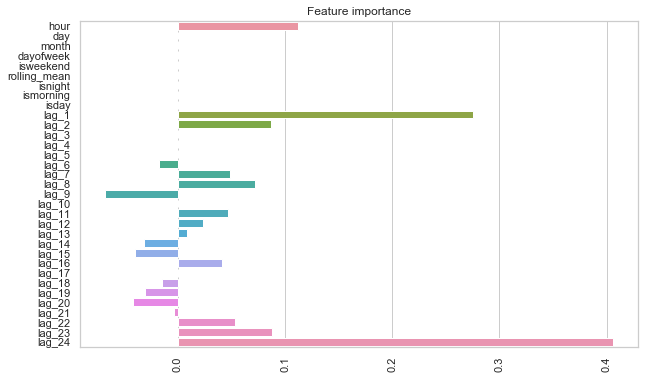

In [33]:
feature_importance = pd.Series(elastic.coef_, index=train_features.columns)
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=feature_importance, y=feature_importance.index);
plt.title('Feature importance', fontsize=12)
plt.xticks(rotation = 90)
plt.show()

Здесь ситуация другая - важность придается часу и лагам, причем наибольший вес - у 24го лага, то есть предыдущего часа. Возможно, здесь мы получаем прогноз близкий "количество заказов будет как в предыдущем часу + корректировка"

Попробуем проделать то же самое для Lasso и Ridge.

### Lasso

In [34]:
best_result = 10000
best_lag = 0
best_alpha = 0

for lag in range(1, 25, 1):
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
    data = data.resample('1H').sum()
        
    make_features(data, 24, lag)
    data.dropna(inplace = True)
        
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train_target = train['num_orders']
    train_features = train.drop(columns='num_orders')
    test_target = test['num_orders']
    test_features = test.drop(columns='num_orders')

    for alpha in [0.1, 0.5, 1.0, 10.0]:
        lasso = Lasso(alpha=alpha, max_iter=2000, random_state=25)
        result = timeseriesCVscore(train_features, train_target, 5, lasso)
        if result < best_result:
            best_result = result
            best_alpha = alpha
            best_lag = lag

print('Лучший результат', best_result, 'получен при лаге', best_lag, ', alpha =', alpha)      

Лучший результат 26.85230615413812 получен при лаге 24 , alpha = 10.0


In [35]:
score_table = (score_table.append({'model': 'Lasso', 'RMSE': best_result}, ignore_index=True));

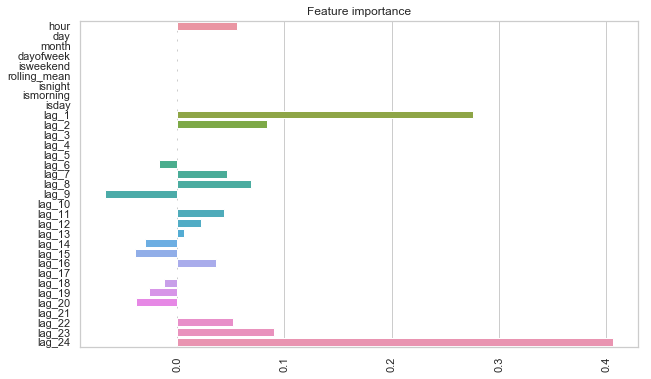

In [36]:
feature_importance = pd.Series(lasso.coef_, index=train_features.columns)
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=feature_importance, y=feature_importance.index);
plt.title('Feature importance', fontsize=12)
plt.xticks(rotation = 90)
plt.show()

Картина близка к предыдущей модели, что логично с учетом веса l1-регуляризации

### Ridge

In [37]:
best_result = 10000
best_lag = 0
best_alpha = 0

for lag in range(1, 25, 1):
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
    data = data.resample('1H').sum()
        
    make_features(data, 24, lag)
    data.dropna(inplace = True)
        
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train_target = train['num_orders']
    train_features = train.drop(columns='num_orders')
    test_target = test['num_orders']
    test_features = test.drop(columns='num_orders')

    for alpha in [0.1, 0.5, 1.0, 10.0]:
        ridge = Ridge(alpha=alpha, max_iter=None, random_state=25)
        result = timeseriesCVscore(train_features, train_target, 5, ridge)
        if result < best_result:
            best_result = result
            best_alpha = alpha
            best_lag = lag

print('Лучший результат', best_result, 'получен при лаге', best_lag, ', alpha =', alpha) 

Лучший результат 26.818441220754124 получен при лаге 24 , alpha = 10.0


In [38]:
score_table = (score_table.append({'model': 'Ridge', 'RMSE': best_result}, ignore_index=True));

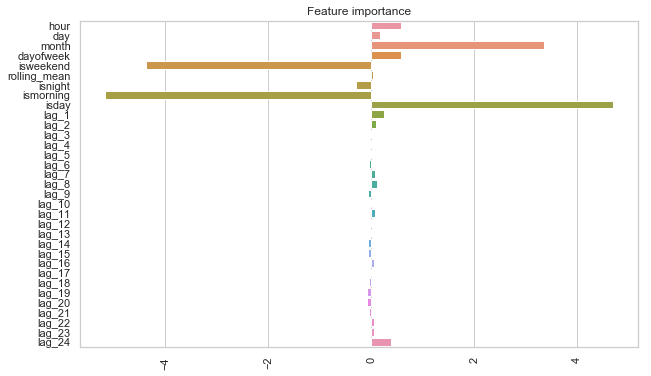

In [39]:
feature_importance = pd.Series(ridge.coef_, index=train_features.columns)
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=feature_importance, y=feature_importance.index);
plt.title('Feature importance', fontsize=12)
plt.xticks(rotation = 90)
plt.show()

Способ настройки Ридж-регрессии похож на обычную линейную - однако наличие регуляризации не позволяет ей придать слишком большой вес одному из параметров. При этом наибольший вес у 24-го лага, т.е. у прошлого часа.

### Метод ближайших соседей

In [40]:
best_result = 10000
best_lag = 0
best_neighbors = 0

for lag in range(1, 25, 1):
    for neighbors in [3, 5, 7, 10, 12]:
        data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
        data = data.resample('1H').sum()
        
        make_features(data, 24, lag)
        data.dropna(inplace = True)
        
        train_data, test_data = train_test_split(data, shuffle=False, test_size=0.1)
        train_target = train_data['num_orders']
        train_features = train_data.drop(columns='num_orders')
        test_target = test_data['num_orders']
        test_features = test_data.drop(columns='num_orders')
        
        knn = KNeighborsRegressor(n_neighbors=neighbors)
        result = timeseriesCVscore(train_features, train_target, 5, knn)
        #print('Для лага', lag, 'значение RMSE', result)
        if best_result > result:
            best_result = result
            best_lag = lag
            best_neighbors = neighbors

print('Лучшее значение RMSE', best_result, 'достигнуто с лагом', best_lag, 'и числом соседей', best_neighbors)        

Лучшее значение RMSE 26.048709187250715 достигнуто с лагом 24 и числом соседей 10


In [41]:
score_table = (score_table.append({'model': 'KNeighborsRegressor', 'RMSE': best_result}, ignore_index=True));

Проверка на адекватность с помощью DummyRegressor

In [42]:
dummy = DummyRegressor()
result = timeseriesCVscore(train_features, train_target, 5, dummy)
print(result)

40.53405633050457


In [43]:
score_table.sort_values(by='RMSE')

,model,RMSE
4,KNeighborsRegressor,26.048709
3,Ridge,26.818441
0,LinearRegression,26.818621
2,Lasso,26.852306
1,ElasticNet,26.862880


### Выводы

Обучены линейные модели и метод ближайших соседей. Обычная линейная регрессия подвержена ошибкам при избыточном числе лагов, модели с регуляризацией этого лишены. Лучшие результаты показал метод ближайших соседей и Ридж-регрессия.

## Тестирование моделей

Тестирование проведем на Методе ближайших соседей, т.к. он показал лучшую метрику, и на Ридж-регресси - т.к. она имеет лучшую метрику среди линейных моделей.

In [44]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
data = data.resample('1H').sum()
        
make_features(data, 24, 24)
data.dropna(inplace = True)
        
train_data, test_data = train_test_split(data, shuffle=False, test_size=0.1)
train_target = train_data['num_orders']
train_features = train_data.drop(columns='num_orders')
test_target = test_data['num_orders']
test_features = test_data.drop(columns='num_orders')

In [45]:
ridge = Ridge(alpha=10.0, max_iter=None, random_state=25)
ridge.fit(train_features, train_target)
prediction = ridge.predict(test_features)

print('RMSE тестирования для Ridge-регрессии', rmse(test_target, prediction))

RMSE тестирования для Ridge-регрессии 45.26548987803048


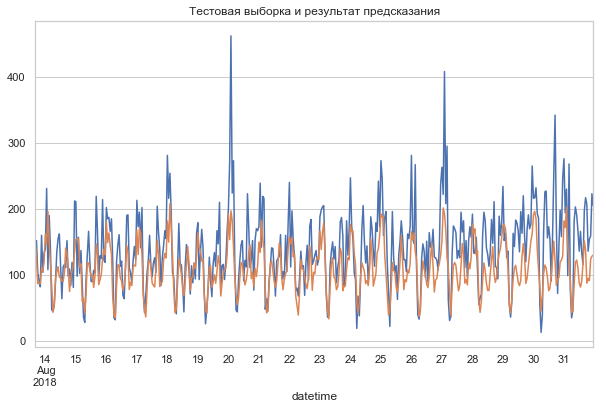

In [53]:
plt.figure(figsize=(10, 6))
ax = test_target.plot()
pd.Series(prediction, index=test_target.index).plot(ax=ax);
plt.title('Тестовая выборка и результат предсказания')
plt.show()

In [46]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(train_features, train_target)
prediction = knn.predict(test_features)

print('RMSE тестирования для метода ближайших соседей', rmse(test_target, prediction))

RMSE тестирования для метода ближайших соседей 49.83503696287291


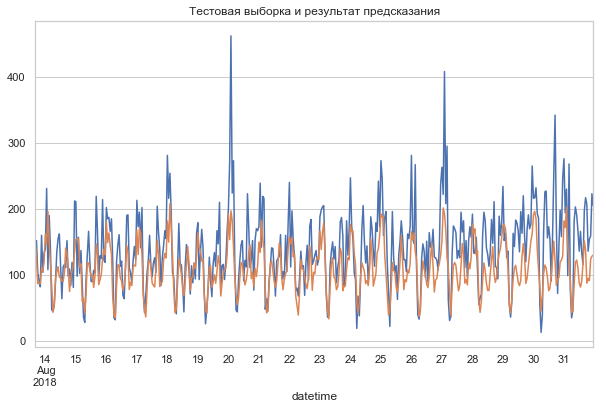

In [54]:
plt.figure(figsize=(10, 6))
ax = test_target.plot()
pd.Series(prediction, index=test_target.index).plot(ax=ax);
plt.title('Тестовая выборка и результат предсказания')
plt.show()

### Выводы

Несмотря на лучший результат при обучении, на тестовой выборке метод ближайших соседей оказался менее успешен. Скорее всего, это связано с особенностями работы модели на временных рядах. Таким образом, линейные модели дают результат лучше.

## Общий вывод

Были исследованы данные о заказах такси в аэропортах в перод с марта по август 2018 года. Были выделены признаки для прогнозирования временного ряда, проведено исследование и обучение моделей для прогнозирования. Лучший результат показала ridge  регрессия с метрикой RMSE = 45,3. </br>
Стоит отметить, что для построения данных использован достаточно небольшой период с постоянно возрастающим благодаря отпускам трендом. В дальнейшем для улучшения точности предсказаний имеет смысл регулярно переобучать модель с появлением новых данных.